# Part Segmentation

In [1]:
# Import libraries
from pathlib import Path
import copy
import time

import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import ipympl

from training.networks import Generator
from torch_utils import misc

import dnnlib
import legacy

In [2]:
def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    %matplotlib inline
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def horizontal_concat(imgs):
    return torch.cat([img.unsqueeze(0) for img in imgs], 3) 

In [3]:
# Setup Constants
DEVICE = "cuda"
OUTDIR = "./cached_genned_images"
SAVE_IMAGES = False

IMAGE_SIZE = 256
TRUNCATION = 0.7 # What is this?
NOISE_MODE = 'const'
NUM_SAMPLES = 3

IMSHOW_SIZE = 3 # What is this?
LATENT_DIMENSION = 256

PAPER256_CFG = dnnlib.EasyDict(ref_gpus=8,  kimg=25000,  mb=64, mbstd=8,  fmaps=0.5, lrate=0.0025, gamma=1, ema=20,  ramp=None, map=8)

FEW_SHOT_TRAINING_ITERATIONS = 100
TEST_DIR = "./test_images"


In [4]:
# Setup Network Arguments - from projector.py
COMMON_KWARGS = dict(
    c_dim=0, # Number of classes -> We have one class c_dim = 0
    img_resolution=IMAGE_SIZE, 
    img_channels=3
)

GEN_KWARGS = dnnlib.EasyDict(
    class_name='training.networks.Generator', 
    z_dim=512, 
    w_dim=512, 
    mapping_kwargs=dnnlib.EasyDict(), 
    synthesis_kwargs=dnnlib.EasyDict()
)

DIS_KWARGS = dnnlib.EasyDict(
    class_name='training.networks.Discriminator', 
    block_kwargs=dnnlib.EasyDict(), 
    mapping_kwargs=dnnlib.EasyDict(), 
    epilogue_kwargs=dnnlib.EasyDict()
)

GEN_KWARGS.synthesis_kwargs.channel_base = DIS_KWARGS.channel_base = int(PAPER256_CFG.fmaps * 32768)
GEN_KWARGS.synthesis_kwargs.channel_max = DIS_KWARGS.channel_max = 512
GEN_KWARGS.synthesis_kwargs.num_fp16_res = DIS_KWARGS.num_fp16_res = 4 # enable mixed-precision training

GEN_KWARGS.synthesis_kwargs.conv_clamp = DIS_KWARGS.conv_clamp = 256 # clamp activations to avoid float16 overflow
GEN_KWARGS.mapping_kwargs.num_layers = PAPER256_CFG.map

DIS_KWARGS.epilogue_kwargs.mbstd_group_size = PAPER256_CFG.mbstd

GEN_OPT_KWARGS = dnnlib.EasyDict(class_name='torch.optim.Adam', lr=PAPER256_CFG.lrate, betas=[0,0.99], eps=1e-8)
DIS_OPT_KWARGS = dnnlib.EasyDict(class_name='torch.optim.Adam', lr=PAPER256_CFG.lrate, betas=[0,0.99], eps=1e-8)

In [6]:
# Load Model
model_path = Path("./trained/network-snapshot-000806.pkl")

generator = dnnlib.util.construct_class_by_name(**GEN_KWARGS, **COMMON_KWARGS).train().requires_grad_(False).to(DEVICE) # subclass of torch.nn.Module
discriminator = dnnlib.util.construct_class_by_name(**DIS_KWARGS, **COMMON_KWARGS).train().requires_grad_(False).to(DEVICE) # subclass of torch.nn.Module
generator_copy = copy.deepcopy(generator).eval()

with dnnlib.util.open_url(str(model_path)) as f:
    resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', generator), ('D', discriminator), ('G_ema', generator_copy)]:
        print("loading: ", name)
        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)


loading:  G
loading:  D
loading:  G_ema


torch.Size([3, 14, 512])
(13,)
sample images:


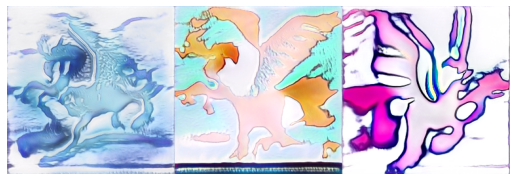

In [73]:
# Generate Images

def mean_latent(n_latent):
    latent_in = torch.randn(
            n_latent, GEN_KWARGS.z_dim, device=DEVICE
    )
    latent = generator.mapping(latent_in, COMMON_KWARGS['c_dim'])
    return latent.mean(0, keepdim=True)


with torch.no_grad():
    trunc_mean = mean_latent(4096).detach().clone()
    
    latent = generator.get_latent(torch.randn(NUM_SAMPLES, GEN_KWARGS.z_dim, device=DEVICE), COMMON_KWARGS['c_dim'])
    imgs_gen, features = generator.synthesis(latent, extract_features=True)
    torch.cuda.empty_cache()

print("sample images:")
imshow(tensor2image(horizontal_concat(imgs_gen)), size=IMSHOW_SIZE*NUM_SAMPLES)


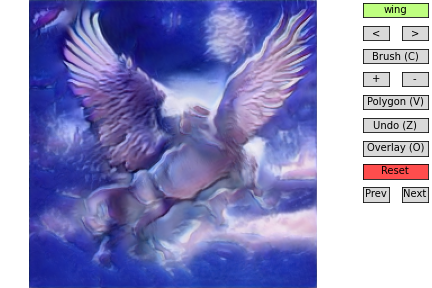

In [26]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import widgets
from matplotlib.colors import hsv_to_rgb

import random
import copy
import cv2

class Labeller:
    def __init__(self, images, classes):
        
        self.n_image = len(images)
        self.img_idx = 0

        self.images = images        
        self._reset_label()
        
        self.classes = classes
        self.n_class = len(classes)
        self.colors = self._sample_colors(self.n_class)
        self.colors[0] = np.array([1., 1., 1.])
        self._class = 1

        self.fig = plt.figure('Simple Labeller')
        self.ax = self.fig.add_subplot()
        self.fig.subplots_adjust(left=0.0, bottom=0.0, right=0.80, top=1.0)

        self.ax.axis('off')
        self.ax_img = self.ax.imshow(self.images[self.img_idx])
        
        self._add_buttons()        
        self.fig.canvas.mpl_connect('key_press_event', self._key_maps)

        self.show_overlay = True
        self.history = []
        self.brush_size = 1
        
        plt.show()
       
    def _sample_colors(self, n=1):
        h = np.linspace(0.0, 1.0, n)[:,np.newaxis]
        s = np.ones((n,1))*0.5
        v = np.ones((n,1))*1.0
        return hsv_to_rgb(np.concatenate([h,s,v], axis=1))

    def _draw(self, image):
        self.ax_img.set_data(image)
        
    def _key_maps(self, event):
        key_maps = {
            'c': self._lasso,
            'v': self._poly,
            'z': self._undo,
            'right': self._next_class,
            'left': self._prev_class,
            'o': self._overlay,
            'up': self._brush_up,
            'down': self._brush_down,
        }
        key = event.key.lower()
        if key in key_maps:
            key_maps[key](None)
        
        
    def _add_buttons(self):
        axes_coords = [0.84, 0.94, 0.15, 0.05]
        interval = 0.08

        self.class_box = widgets.Button(plt.axes(axes_coords),
                                        self.classes[self._class],
                                        color=self.colors[self._class],
                                        hovercolor=self.colors[self._class])

        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.prev_class = widgets.Button(plt.axes(axes_coords_split), '<')
        self.cid_prev_class = self.prev_class.on_clicked(self._prev_class)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.next_class = widgets.Button(plt.axes(axes_coords_split), '>')
        self.cid_next_class = self.next_class.on_clicked(self._next_class)
        
        axes_coords[1] -= interval
        self.lasso = widgets.Button(plt.axes(axes_coords), 'Brush (C)')
        self.cid_lasso = self.lasso.on_clicked(self._lasso)

        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.brush_up = widgets.Button(plt.axes(axes_coords_split), '+')
        self.cid_brush_up = self.brush_up.on_clicked(self._brush_up)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.brush_down = widgets.Button(plt.axes(axes_coords_split), '-')
        self.cid_brush_down = self.brush_down.on_clicked(self._brush_down)
        
        axes_coords[1] -= interval
        self.poly = widgets.Button(plt.axes(axes_coords), 'Polygon (V)')
        self.cid_poly = self.poly.on_clicked(self._poly)
        
        axes_coords[1] -= interval
        self.undo = widgets.Button(plt.axes(axes_coords), 'Undo (Z)')
        self.cid_undo = self.undo.on_clicked(self._undo)

        axes_coords[1] -= interval
        self.overlay = widgets.Button(plt.axes(axes_coords), 'Overlay (O)')
        self.cid_overlay = self.overlay.on_clicked(self._overlay)
        
        axes_coords[1] -= interval
        self.reset = widgets.Button(plt.axes(axes_coords), 'Reset',
                                    color=[1, 0.3, 0.3], hovercolor=[1, 0.5, 0.5])
        self.cid_reset = self.reset.on_clicked(self._reset)
        
        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.prev_img = widgets.Button(plt.axes(axes_coords_split), 'Prev')
        self.cid_prev_img = self.prev_img.on_clicked(self._prev_img)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.next_img = widgets.Button(plt.axes(axes_coords_split), 'Next')
        self.cid_next_img = self.next_img.on_clicked(self._next_img)
        
    def _next_class(self, event):
        self._class = (self._class + 1) % self.n_class
        self._update_class_box()
        
    def _prev_class(self, event):
        self._class = (self._class - 1) % self.n_class
        self._update_class_box()

    def _update_class_box(self):
        self.class_box.label.set_text(self.classes[self._class])
        self.class_box.color = self.colors[self._class]
        self.class_box.hovercolor = self.class_box.color
        self.fig.canvas.draw()
        
    def _undo(self, event):
        if len(self.history) > 0:
            self.history.pop(-1)
            self._reset_label(only_current_img=True)
            for inputs in self.history:
                self._update_label(inputs)
            self._draw(self.get_image_label_overlay())

    def _overlay(self, event):
        self.show_overlay = not self.show_overlay
        if self.show_overlay:
            self._draw(self.get_image_label_overlay())
        else:
            self._draw(self.images[self.img_idx])
    
    def _reset(self, event):
        self.history = []
        self._reset_label(only_current_img=True)
        self._draw(self.images[self.img_idx])

    def _next_img(self, event):
        self.img_idx = (self.img_idx + 1) % self.n_image
        self._on_img_change()

    def _prev_img(self, event):
        self.img_idx = (self.img_idx - 1) % self.n_image
        self._on_img_change()

    def _on_img_change(self):
        self.history = []
        self.show_overlay = True        
        self._draw(self.get_image_label_overlay())
        
    def _poly(self, event):
        self._reset_selectors()
        self.poly_selector = widgets.PolygonSelector(self.ax, self._process_polygon)
    
    def _process_polygon(self, vert):
        polygon = np.array(vert, np.int32).reshape((-1, 1, 2))
        inputs = ('poly', polygon, self._class)
        self.history.append(inputs)
        self._update_label(inputs)
        self._after_new_label()
        self._reset_selectors()

    def _brush_up(self, dummy):
        self.brush_size += 1
        
    def _brush_down(self, dummy):
        self.brush_size = max(self.brush_size-1, 1)
        
    def _lasso(self, event):
        self._reset_selectors()        
        self.lasso_selector = widgets.LassoSelector(
            self.ax, self._process_lasso, lineprops=dict(linewidth=self.brush_size//2)
        )
    
    def _process_lasso(self, vert):
        path = np.array(vert, np.int32).reshape((-1, 1, 2))
        path = np.unique(path, axis=1)
        inputs = ('lasso', path, self._class, self.brush_size)
        self.history.append(inputs)
        self._update_label(inputs)
        self._after_new_label()
        self._reset_selectors()

    def _reset_selectors(self):
        if hasattr(self, 'lasso_selector'):
            self.lasso_selector.set_visible(False)
            del(self.lasso_selector)
        if hasattr(self, 'poly_selector'):
            self.poly_selector.set_visible(False)            
            del(self.poly_selector)
    
    def _after_new_label(self):
        self.show_overlay = True
        self._draw(self.get_image_label_overlay())
            
    def _reset_label(self, only_current_img=False):
        if only_current_img:
            self.labels[self.img_idx] = np.zeros(
                (self.images.shape[1], self.images.shape[2]),
                np.uint8
            )
        else:
            self.labels = np.zeros(
                (self.n_image, self.images.shape[1], self.images.shape[2]),
                np.uint8
            )
        
    def _update_label(self, inputs):
        if inputs[0] == 'poly':
            self.labels[self.img_idx] = cv2.fillPoly(
                self.labels[self.img_idx], [inputs[1]], inputs[2], 0
            )
        elif inputs[0] == 'lasso':
            self.labels[self.img_idx] = cv2.polylines(
                self.labels[self.img_idx], [inputs[1]], isClosed=False,
                color=inputs[2], thickness=inputs[3]
            )
        
    def get_image_label_overlay(self):
        overlay = self.images[self.img_idx].copy()
        label_image = self.get_visualized_label()
        non_zeros = label_image > 0
        overlay[non_zeros] = label_image[non_zeros]
        return overlay
        
    def get_visualized_label(self, label=None):
        if label is None:
            label = self.labels[self.img_idx]
        
        label_image = np.zeros_like(self.images[self.img_idx])
        for c in range(1,self.n_class):
            label_image[label == c] = self.colors[c]
        return label_image
    
    def get_labels(self):
        return self.labels

# set classes here
classes = ['background', 'wing', 'tail', 'horse_leg', 'horse_head'] #, 'nose', 'mouth', 'ear']
        
labeller = Labeller(imgs_gen.clamp_(-1., 1.).detach().permute(0,2,3,1).cpu().numpy() * 0.5 + 0.5, classes)

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f5f408c3f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/weakref.py", line 55, in _cb
    if self._alive:
AttributeError: 'NoneType' object has no attribute '_alive'


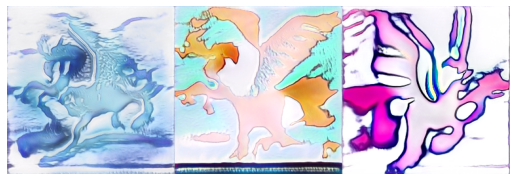

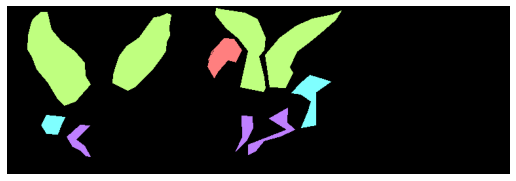

(13,)


RuntimeError: CUDA out of memory. Tried to allocate 3.28 GiB (GPU 0; 7.93 GiB total capacity; 4.25 GiB already allocated; 2.67 GiB free; 4.57 GiB reserved in total by PyTorch)

In [74]:
labels = labeller.get_labels()

imshow(tensor2image(horizontal_concat(imgs_gen)), size=IMSHOW_SIZE*NUM_SAMPLES)
imshow(np.concatenate([labeller.get_visualized_label(l) for l in labels], axis=1), size=IMSHOW_SIZE*NUM_SAMPLES)

@torch.no_grad()
def concat_features(features):
    h = max([f.shape[-2] for f in features])
    w = max([f.shape[-1] for f in features])
    return torch.cat([torch.nn.functional.interpolate(f, (h,w), mode='nearest') for f in features], dim=1)

data = dict(
    latents=latent.cpu(),
    features=concat_features(features).cpu(),
    labels=torch.tensor(labels).long(),
)

print(f'Dataset for {NUM_SAMPLES}-Shot Training is Prepared')

In [28]:
import torch.nn.functional as F
from fewshot import FewShotCNN

device = "cuda"
net = FewShotCNN(data['features'].shape[1], len(classes), size='S')

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

net.train().to(device)
start_time = time.time()
for epoch in range(1, 100+1):
    sample_order = list(range(NUM_SAMPLES))
    random.shuffle(sample_order)

    for idx in sample_order:
        
        sample = data['features'][idx].unsqueeze(0).to(device)
        label = data['labels'][idx].unsqueeze(0).to(device)

        out = net(sample)
        
        loss = F.cross_entropy(out, label, reduction='mean')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f'{epoch:5}-th epoch | loss: {loss.item():6.4f} | time: {time.time()-start_time:6.1f}sec')

    scheduler.step()
print('Done!')

   50-th epoch | loss: 0.3988 | time:   42.3sec
  100-th epoch | loss: 0.0260 | time:   84.5sec
Done!


(13,)


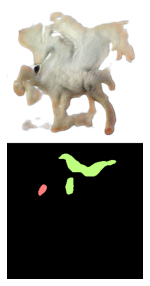

(13,)


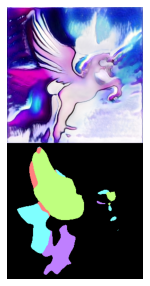

(13,)


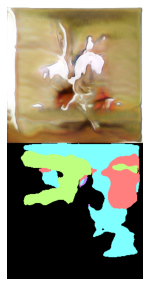

(13,)


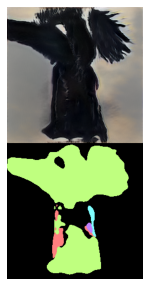

In [90]:
n_test = 4

generator.eval().to(DEVICE)
net.eval().to(DEVICE)

latents = []
features = []
imgs_gen = []
with torch.no_grad():
    for i in range(n_test):
        torch.cuda.empty_cache()
        latent = generator.get_latent(torch.randn(1, GEN_KWARGS.z_dim, device=DEVICE), COMMON_KWARGS['c_dim'])
        img_gen, feature = generator.synthesis(latent, extract_features=True)
        latents.append(latent)
        imgs_gen.append(img_gen)
        features.append(feature)

latents = np.array(latents)
features = np.array(features)
imgs_gen = np.array(imgs_gen)

with torch.no_grad():
    for latent, feature, img_gen in zip(latents, features, imgs_gen):
        torch.cuda.empty_cache()
        out = net(concat_features(feature))
        predictions = out.data.max(1)[1].cpu().numpy()

        # visualize
        predictions = np.concatenate([labeller.get_visualized_label(pred) for pred in predictions], axis=1)
        results = np.concatenate([tensor2image(horizontal_concat(img_gen)), predictions], axis=0)
        imshow(results, size=5*1)
